In [22]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import accuracy_score



## Read the data

Loading data into dataframe from 'citation_sentiment_corpus.txt'

In [23]:
data = pd.read_csv('citation_sentiment_corpus.txt', sep="\t", header=None)
data.columns = ["Source_Paper_ID", "Target_Paper_ID", "Sentiment", "Citation_Text"]
data.tail()

Source_Paper_ID Target_Paper_ID Sentiment  \
8731        W98-1118        W96-0213         p   
8732        W99-0606        W96-0213         o   
8733        W99-0607        W96-0213         o   
8734        W99-0607        W96-0213         p   
8735        W99-0608        W96-0213         o   

                                          Citation_Text  
8731  He has achieved state-of-the art results by ap...  
8732  B = (Brill and Wu, 1998); M = (Magerman, 1995)...  
8733  The model we use is similar to that of (Ratnap...  
8734  Our model exploits the same kind of tag-n-gram...  
8735  In that table, TBL stands for Brill's transfor...

### Removing duplicate data

In [24]:
print ("Original:", data.shape)
data = data.drop_duplicates()
data = data.reset_index(drop=True)
print ("Drop Dupicates:", data.shape)

Original: (8736, 4)
Drop Dupicates: (8734, 4)


### Adding lemmatized citation text to data frame

In [25]:
lemmatizer = WordNetLemmatizer() 
def lemmatize(cite_text):
    result = []
    for text in cite_text.values:
        
        #Lowercasing before negation
        lower_case = text.lower()
        #Lemmatization
        lemm = lemmatizer.lemmatize(lower_case)
        result.append(lemm)
        
    return result

data['lemmatized_text']= lemmatize(data['Citation_Text'])


# Word2Vec

In [ ]:
# Create average word vectors
# Average all of the word vectors in a given citation sentence

#Load the data as tokens as we split each string of citation text
sentences = [_text.split() for _text in data['Citation_Text']]
# Set values for various parameters
num_features = 500    # Word vector dimensionality
min_word_count = 10   # Minimum word count
context = 3          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words 
# Initialize and train the model
model = Word2Vec(size=num_features,min_count = min_word_count,
                 window = context,sample = downsampling, seed=1, workers=8)
model.build_vocab(sentences)

# save the model for later using Word2Vec.load()
model_name = "citation_word2vec"
model.save(model_name)

In [ ]:
# words is a list that contains words in the model's vocabulary#
words = model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

In [ ]:
model.train(sentences, total_examples=len(sentences), epochs=32)

In [ ]:
model.most_similar("observe")

In [ ]:
def makeFeatureVec(sentence, model, num_features):
# Function to average all of the word vectors in a given sentence
    featureVec = np.zeros((num_features,),dtype="float32")
    words = set(model.wv.index2word)
    nwords=0
# Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word,i in sentence:
        if word in words:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
# Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [ ]:
def getAvgFeatureVecs(sentence, model, num_features):
# Given the citation sentences, calculating the average feature vector
    # Initialize
    counter = 0
    FeatureVecs = np.zeros((len(sentences),num_features), dtype="float32")
    for sentence in sentences:
        if counter%100 == 0:
            print("Review %d of %d"%(counter,len(sentences)))
        FeatureVecs[counter] = makeFeatureVec(sentence, model ,num_features)
        counter = counter + 1
    return FeatureVecs

In [ ]:
# Calculating average feature vector for training set
trainDataVecs = getAvgFeatureVecs(sentences, model, num_features)

# Lexicons

In [ ]:
polar_data = pd.read_csv('polar_phrases.txt', sep="\t", header=None)
polar_data.columns = ["Phrase", "Polarity"]
polar_data.tail()
phrase_len = len(polar_data['Phrase'])

In [ ]:
counter = 0
LexiconFeatures = np.zeros(len(sentences), dtype="float32")
for sentence in sentences:
    for word in sentence:
        score = 0
        for i in range(phrase_len):
            if word==polar_data['Phrase'][i]:
                score = score+ polar_data['Polarity'][i]
    LexiconFeatures[counter] = score
    print(LexiconFeatures[counter])
    counter = counter + 1

In [ ]:
data['lexicon_count'] = LexiconFeatures

### Train and test split on citation text

In [26]:
corpus = data['Citation_Text']
num_training = 7000
train_X = corpus[:num_training]
test_X = corpus[num_training:]
train_Y = data['Sentiment'][:num_training]
test_Y=data['Sentiment'][num_training:]

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1,3) ,min_df=1, use_idf=True, smooth_idf=True)

# Vectorize the training data
X_train = vectorizer.fit_transform(train_X)
# Vectorize the test data
X_test = vectorizer.transform(test_X)
svm_C = 1000

# Train the SVM, optimized by Stochastic Gradient Descent 
clf = SVC(probability=True, verbose=False, class_weight=None, kernel="rbf")

clf.fit(X_train, train_Y) 

# Make predictions
pred = clf.predict(X_test)


In [28]:
print (accuracy_score(Y_test, pred))


0.8592848904267589


In [17]:
from sklearn import metrics

matrix = metrics.confusion_matrix(Y_test, pred)

In [18]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

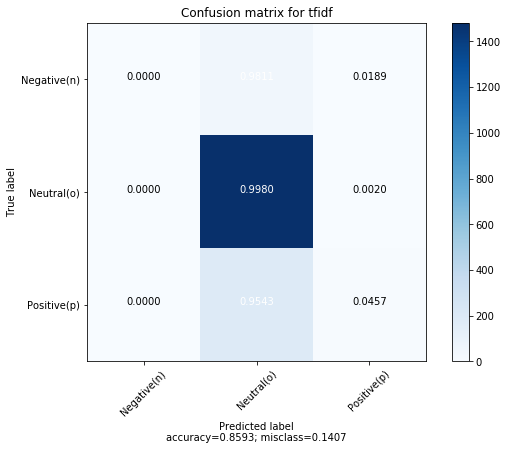

In [19]:
target_names = ["Negative(n)", "Neutral(o)", "Positive(p)"]
plot_confusion_matrix(matrix,
                          target_names,
                          title='Confusion matrix for tfidf',
                          cmap=None,
                          normalize=True)